### Цирулев Н.В. М8О-408Б-22
# Лабораторная работа №3 (Проведение исследований с решающим деревом)

In [8]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TEST_SIZE = 0.2

TUNE_N_CLF = 20000
CV_SPLITS_CLF = 2

CV_SPLITS_REG = 5


def eval_clf(y_true, y_pred, title: str):
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"precision: {precision:.6f}")
    print(f"recall:    {recall:.6f}")
    print(f"f1:        {f1:.6f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["legitimate(0)", "phishing(1)"]).plot(values_format="d")
    plt.title(title)
    plt.show()

    return {"precision": precision, "recall": recall, "f1": f1}


def eval_reg(y_true, y_pred, title: str):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {title} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2:   {r2:.5f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def load_from_kagglehub(dataset_id: str) -> pd.DataFrame:
    path = kagglehub.dataset_download(dataset_id)
    root = Path(path)
    csv_path = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    print("Loaded:", dataset_id)
    print("CSV:", csv_path)
    print("Shape:", df.shape)
    return df


def parse_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan


def clean_laptop(df_in: pd.DataFrame) -> pd.DataFrame:
    dfc = df_in.copy()
    dfc.columns = dfc.columns.str.strip()

    for col in ["ram_gb", "ssd", "hdd", "graphic_card_gb", "os_bit", "rating", "processor_gnrtn"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].map(parse_number)

    if "Price" in dfc.columns:
        dfc["Price"] = pd.to_numeric(dfc["Price"], errors="coerce")

    for col in ["Number of Ratings", "Number of Reviews"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc

### Имплементация алгоритма:

In [9]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

class DecisionTreeScratchHist:
    def __init__(
        self,
        task="classification",
        criterion="gini",
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        max_bins=64,
        random_state=42
    ):
        self.task = task
        self.criterion = criterion
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.max_bins = int(max_bins)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)

        self.n_features_ = None
        self.root_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y)
        self.n_features_ = X.shape[1]
        self.root_ = self._build(X, y, depth=0)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        out = np.empty(X.shape[0], dtype=np.float32 if self.task == "regression" else np.int32)
        for i in range(X.shape[0]):
            out[i] = self._predict_one(self.root_, X[i])
        return out.astype(np.int32) if self.task == "classification" else out

    def _predict_one(self, node, x):
        while not node["is_leaf"]:
            if x[node["feat"]] <= node["thr"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["value"]

    def _stop(self, y, depth, n):
        if self.max_depth is not None and depth >= self.max_depth:
            return True
        if n < self.min_samples_split:
            return True
        if self.task == "classification":
            return np.all(y == y[0])
        return n <= 2

    def _leaf_value(self, y):
        if self.task == "classification":
            vals, cnts = np.unique(y, return_counts=True)
            return int(vals[np.argmax(cnts)])
        return float(np.mean(y)) if y.size else 0.0

    def _feature_subset(self):
        p = self.n_features_
        mf = self.max_features
        if mf is None:
            return np.arange(p)
        if isinstance(mf, str):
            if mf == "sqrt":
                k = max(1, int(np.sqrt(p)))
            elif mf == "log2":
                k = max(1, int(np.log2(p)))
            else:
                k = p
        elif isinstance(mf, float):
            k = max(1, int(p * mf))
        else:
            k = max(1, int(mf))
        k = min(p, k)
        return self._rng.choice(p, size=k, replace=False)

    def _impurity_clf(self, n0, n1):
        tot = n0 + n1
        if tot <= 0:
            return 0.0
        p0 = n0 / tot
        p1 = n1 / tot
        if self.criterion == "entropy":
            out = 0.0
            if p0 > 0:
                out -= p0 * np.log2(p0)
            if p1 > 0:
                out -= p1 * np.log2(p1)
            return float(out)
        return float(1.0 - (p0 * p0 + p1 * p1))

    def _best_split_clf(self, X, y):
        n, _ = X.shape
        y = y.astype(np.int32)

        total1 = int(y.sum())
        total0 = int(n - total1)

        best_feat = None
        best_thr = None
        best_score = np.inf

        feats = self._feature_subset()

        for j in feats:
            col = X[:, j]
            cmin = float(np.nanmin(col))
            cmax = float(np.nanmax(col))
            if not np.isfinite(cmin) or not np.isfinite(cmax) or cmin == cmax:
                continue

            is_binary = np.all((col == 0.0) | (col == 1.0))
            if is_binary:
                thr = 0.5
                left_mask = col <= thr
                nl = int(left_mask.sum())
                nr = n - nl
                if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
                    continue
                yl = y[left_mask]
                left1 = int(yl.sum())
                left0 = nl - left1
                right1 = total1 - left1
                right0 = total0 - left0
                score = (nl / n) * self._impurity_clf(left0, left1) + (nr / n) * self._impurity_clf(right0, right1)
                if score < best_score:
                    best_score = score
                    best_feat = j
                    best_thr = float(thr)
                continue

            denom = (cmax - cmin) if (cmax > cmin) else 1.0
            bins = self.max_bins
            scaled = (col - cmin) / denom
            idx = np.floor(scaled * bins).astype(np.int32)
            idx = np.clip(idx, 0, bins - 1)

            cnt = np.bincount(idx, minlength=bins).astype(np.int32)
            ones = np.bincount(idx, weights=y, minlength=bins).astype(np.float64)

            left_cnt = np.cumsum(cnt)
            left_ones = np.cumsum(ones)
            right_cnt = n - left_cnt
            right_ones = total1 - left_ones

            valid = (left_cnt >= self.min_samples_leaf) & (right_cnt >= self.min_samples_leaf)
            if not np.any(valid):
                continue

            left1 = left_ones
            left0 = left_cnt - left1
            right1 = right_ones
            right0 = right_cnt - right1

            imp_left = np.vectorize(self._impurity_clf)(left0, left1)
            imp_right = np.vectorize(self._impurity_clf)(right0, right1)
            score_all = (left_cnt / n) * imp_left + (right_cnt / n) * imp_right
            score_all[~valid] = np.inf

            k = int(np.argmin(score_all))
            score = float(score_all[k])
            if np.isfinite(score) and score < best_score:
                thr = cmin + ((k + 1) / bins) * denom
                best_score = score
                best_feat = j
                best_thr = float(thr)

        return best_feat, best_thr

    def _best_split_reg(self, X, y):
        n, _ = X.shape
        y = y.astype(np.float32)

        best_feat = None
        best_thr = None
        best_score = np.inf

        feats = self._feature_subset()

        for j in feats:
            col = X[:, j]
            cmin = float(np.nanmin(col))
            cmax = float(np.nanmax(col))
            if not np.isfinite(cmin) or not np.isfinite(cmax) or cmin == cmax:
                continue

            is_binary = np.all((col == 0.0) | (col == 1.0))
            if is_binary:
                thr = 0.5
                left_mask = col <= thr
                nl = int(left_mask.sum())
                nr = n - nl
                if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
                    continue
                yl = y[left_mask]
                yr = y[~left_mask]
                sse = float(((yl - yl.mean()) ** 2).sum() + ((yr - yr.mean()) ** 2).sum())
                if sse < best_score:
                    best_score = sse
                    best_feat = j
                    best_thr = float(thr)
                continue

            denom = (cmax - cmin) if (cmax > cmin) else 1.0
            bins = self.max_bins
            scaled = (col - cmin) / denom
            idx = np.floor(scaled * bins).astype(np.int32)
            idx = np.clip(idx, 0, bins - 1)

            cnt = np.bincount(idx, minlength=bins).astype(np.float64)
            sumy = np.bincount(idx, weights=y, minlength=bins).astype(np.float64)
            sumy2 = np.bincount(idx, weights=(y * y), minlength=bins).astype(np.float64)

            left_cnt = np.cumsum(cnt)
            left_sum = np.cumsum(sumy)
            left_sum2 = np.cumsum(sumy2)

            right_cnt = n - left_cnt
            right_sum = sumy.sum() - left_sum
            right_sum2 = sumy2.sum() - left_sum2

            valid = (left_cnt >= self.min_samples_leaf) & (right_cnt >= self.min_samples_leaf)
            if not np.any(valid):
                continue

            left_sse = left_sum2 - (left_sum * left_sum) / np.maximum(left_cnt, 1e-12)
            right_sse = right_sum2 - (right_sum * right_sum) / np.maximum(right_cnt, 1e-12)
            sse_all = left_sse + right_sse
            sse_all[~valid] = np.inf

            k = int(np.argmin(sse_all))
            score = float(sse_all[k])
            if np.isfinite(score) and score < best_score:
                thr = cmin + ((k + 1) / bins) * denom
                best_score = score
                best_feat = j
                best_thr = float(thr)

        return best_feat, best_thr

    def _build(self, X, y, depth):
        n = X.shape[0]
        if self._stop(y, depth, n):
            return {"is_leaf": True, "value": self._leaf_value(y)}

        if self.task == "classification":
            feat, thr = self._best_split_clf(X, y)
        else:
            feat, thr = self._best_split_reg(X, y)

        if feat is None or thr is None:
            return {"is_leaf": True, "value": self._leaf_value(y)}

        col = X[:, feat]
        left_mask = col <= thr
        nl = int(left_mask.sum())
        nr = n - nl
        if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
            return {"is_leaf": True, "value": self._leaf_value(y)}

        Xl, yl = X[left_mask], y[left_mask]
        Xr, yr = X[~left_mask], y[~left_mask]

        return {
            "is_leaf": False,
            "feat": int(feat),
            "thr": float(thr),
            "left": self._build(Xl, yl, depth + 1),
            "right": self._build(Xr, yr, depth + 1),
        }

### Классификация

Loaded: ndarvind/phiusiil-phishing-url-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\ndarvind\phiusiil-phishing-url-dataset\versions\1\PhiUSIIL_Phishing_URL_Dataset.csv
Shape: (235795, 55)

=== baseline_sklearn_tree_clf ===
precision: 1.000000
recall:    0.999653
f1:        0.999827


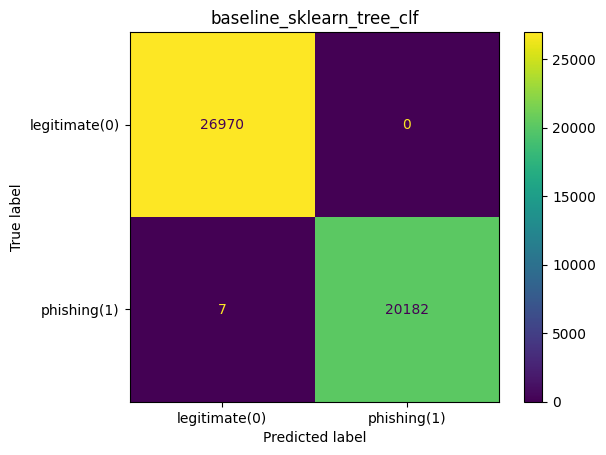

Fitting 2 folds for each of 720 candidates, totalling 1440 fits

=== improved_sklearn_tree_clf ===
precision: 1.000000
recall:    1.000000
f1:        1.000000


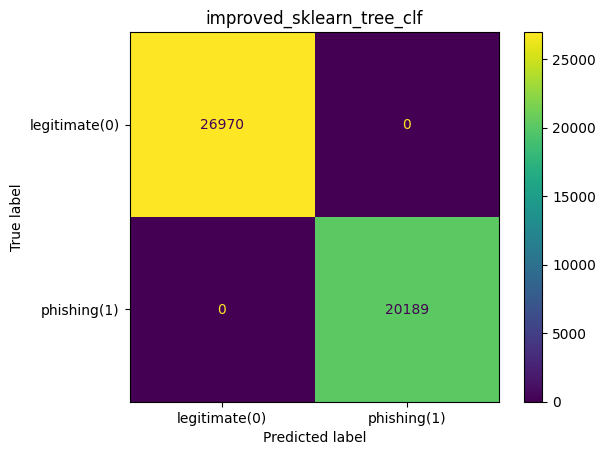


Best params (clf): {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

=== baseline_scratch_tree_clf ===
precision: 1.000000
recall:    0.999802
f1:        0.999901


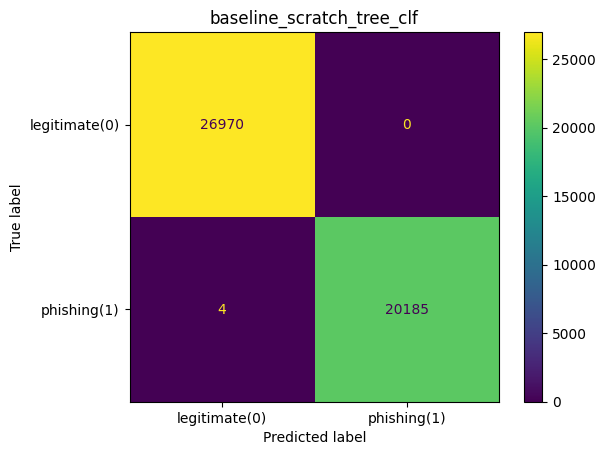


=== improved_scratch_tree_clf ===
precision: 1.000000
recall:    0.999802
f1:        0.999901


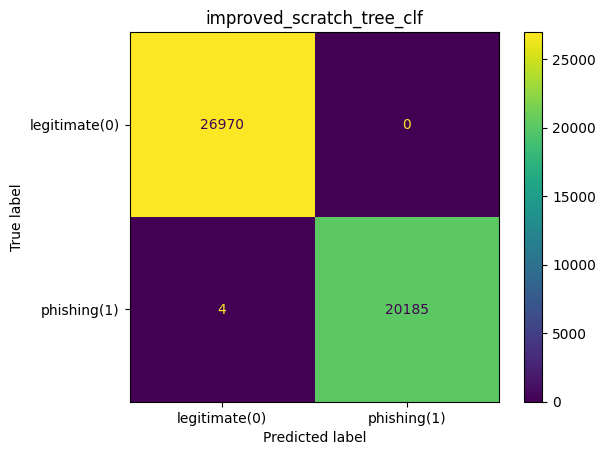


Classification comparison:


,precision,recall,f1
baseline_sklearn,1.0,0.999653,0.999827
improved_sklearn,1.0,1.000000,1.000000
baseline_scratch,1.0,0.999802,0.999901
improved_scratch,1.0,0.999802,0.999901


In [10]:
df_clf = load_from_kagglehub("ndarvind/phiusiil-phishing-url-dataset")

y_clf = (df_clf["label"] == 0).astype(int)
X_clf = df_clf.drop(columns=["label"])

text_cols_clf = [c for c in ["URL", "Domain", "TLD", "Title"] if c in X_clf.columns]
num_cols_clf = [c for c in X_clf.columns if c not in text_cols_clf]

X_train_clf_df, X_test_clf_df, y_train_clf, y_test_clf = train_test_split(
    X_clf[num_cols_clf], y_clf,
    test_size=TEST_SIZE,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

X_train_clf = X_train_clf_df.to_numpy(dtype=np.float32)
X_test_clf = X_test_clf_df.to_numpy(dtype=np.float32)

tree_clf_base = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=3,
    min_samples_leaf=20,
    criterion="gini"
)
tree_clf_base.fit(X_train_clf, y_train_clf)
pred_base_clf = tree_clf_base.predict(X_test_clf)
baseline_sklearn_clf = eval_clf(y_test_clf, pred_base_clf, "baseline_sklearn_tree_clf")

# Гипотезы: подбор max_depth/min_samples_leaf/min_samples_split/max_features/ccp_alpha по CV улучшит F1 за счёт контроля сложности дерева.
tune_n = min(TUNE_N_CLF, len(X_train_clf))
X_tune_clf, _, y_tune_clf, _ = train_test_split(
    X_train_clf, y_train_clf,
    train_size=tune_n,
    stratify=y_train_clf,
    random_state=RANDOM_STATE
)

param_grid_clf = {
    "max_depth": [3, 5, 8, 12, 20],
    "min_samples_leaf": [1, 5, 20, 100],
    "min_samples_split": [2, 10, 50],
    "max_features": [None, "sqrt"],
    "criterion": ["gini", "entropy"],
    "ccp_alpha": [0.0, 1e-5, 1e-4],
}

cv_clf = StratifiedKFold(n_splits=CV_SPLITS_CLF, shuffle=True, random_state=RANDOM_STATE)

search_clf = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_clf,
    scoring="f1",
    refit=True,
    cv=cv_clf,
    n_jobs=-1,
    verbose=2
)
search_clf.fit(X_tune_clf, y_tune_clf)

best_tree_clf = search_clf.best_estimator_
best_tree_clf.fit(X_train_clf, y_train_clf)
pred_impr_clf = best_tree_clf.predict(X_test_clf)
improved_sklearn_clf = eval_clf(y_test_clf, pred_impr_clf, "improved_sklearn_tree_clf")

best_params_clf = search_clf.best_params_
print("\nBest params (clf):", best_params_clf)

scratch_base_clf = DecisionTreeScratchHist(
    task="classification",
    criterion=tree_clf_base.criterion,
    max_depth=tree_clf_base.max_depth,
    min_samples_split=tree_clf_base.min_samples_split,
    min_samples_leaf=tree_clf_base.min_samples_leaf,
    max_features=tree_clf_base.max_features,
    max_bins=64,
    random_state=RANDOM_STATE
)
scratch_base_clf.fit(X_train_clf, y_train_clf.to_numpy() if hasattr(y_train_clf, "to_numpy") else y_train_clf)
pred_s_base_clf = scratch_base_clf.predict(X_test_clf)
baseline_scratch_clf = eval_clf(y_test_clf, pred_s_base_clf, "baseline_scratch_tree_clf")

scratch_impr_clf = DecisionTreeScratchHist(
    task="classification",
    criterion=best_params_clf["criterion"],
    max_depth=best_params_clf["max_depth"],
    min_samples_split=best_params_clf["min_samples_split"],
    min_samples_leaf=best_params_clf["min_samples_leaf"],
    max_features=best_params_clf["max_features"],
    max_bins=64,
    random_state=RANDOM_STATE
)
scratch_impr_clf.fit(X_train_clf, y_train_clf.to_numpy() if hasattr(y_train_clf, "to_numpy") else y_train_clf)
pred_s_impr_clf = scratch_impr_clf.predict(X_test_clf)
improved_scratch_clf = eval_clf(y_test_clf, pred_s_impr_clf, "improved_scratch_tree_clf")

compare_clf = pd.DataFrame(
    [baseline_sklearn_clf, improved_sklearn_clf, baseline_scratch_clf, improved_scratch_clf],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nClassification comparison:")
display(compare_clf)

#### Выводы (классификация)
В sklearn базовое дерево уже показало очень высокое качество: precision=1.0, recall=0.999653, f1=0.999827. После улучшения (подбор гиперпараметров на кросс-валидации) метрики стали precision=1.0, recall=1.0, f1=1.0, т.е. на тестовой выборке улучшение проявилось именно в доведении полноты (recall) до 1.0.

В scratch результаты близкие, но не полностью совпадают со sklearn: для baseline recall=0.999802, f1=0.999901. При этом значения baseline_scratch и improved_scratch получились одинаковыми, то есть улучшение в реализованном в работе алгоритме фактически не сработало. Причина в том, что в sklearn в улучшении участвовал параметр ccp_alpha (cost-complexity pruning), а в написанной реализации pruning по ccp_alpha не реализован, поэтому часть улучшений из sklearn она не может повторить. Из-за этого улучшенный sklearn и улучшенный scratch нельзя считать полностью эквивалентными по условиям.

### Регрессия

In [11]:
df_reg_raw = load_from_kagglehub("anubhavgoyal10/laptop-prices-dataset")
df_reg = clean_laptop(df_reg_raw).dropna(subset=["Price"]).reset_index(drop=True)

y_reg = df_reg["Price"].astype(float)
X_reg = df_reg.drop(columns=["Price"])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

num_cols_reg = [c for c in X_train_reg.columns if pd.api.types.is_numeric_dtype(X_train_reg[c])]
cat_cols_reg = [c for c in X_train_reg.columns if c not in num_cols_reg]

try:
    ohe_base = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe_base = OneHotEncoder(handle_unknown="ignore", sparse=True)

prep_base_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_reg),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe_base)]), cat_cols_reg),
    ],
    remainder="drop"
)

Xtr_reg_base = prep_base_reg.fit_transform(X_train_reg)
Xte_reg_base = prep_base_reg.transform(X_test_reg)

if hasattr(Xtr_reg_base, "toarray"):
    Xtr_reg_base = Xtr_reg_base.toarray()
    Xte_reg_base = Xte_reg_base.toarray()

Xtr_reg_base = np.asarray(Xtr_reg_base, dtype=np.float32)
Xte_reg_base = np.asarray(Xte_reg_base, dtype=np.float32)

tree_reg_base = DecisionTreeRegressor(
    random_state=RANDOM_STATE,
    max_depth=3,
    min_samples_leaf=10
)
tree_reg_base.fit(Xtr_reg_base, y_train_reg)
pred_base_reg = tree_reg_base.predict(Xte_reg_base)
baseline_sklearn_reg = eval_reg(y_test_reg, pred_base_reg, "baseline_sklearn_tree_reg")

# Гипотезы: подбор max_depth/min_samples_leaf/min_samples_split/max_features по CV улучшит MAE/RMSE/R2 за счёт контроля сложности дерева.
param_grid_reg = {
    "tree__max_depth": [3, 5, 8, 12, 20],
    "tree__min_samples_leaf": [1, 5, 10, 20, 50],
    "tree__min_samples_split": [2, 10, 50],
    "tree__max_features": [None, "sqrt", 0.5],
}

pipe_reg = Pipeline([
    ("prep", prep_base_reg),
    ("tree", DecisionTreeRegressor(random_state=RANDOM_STATE)),
])

cv_reg = KFold(n_splits=CV_SPLITS_REG, shuffle=True, random_state=RANDOM_STATE)

search_reg = GridSearchCV(
    pipe_reg,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv_reg,
    n_jobs=-1,
    verbose=2
)
search_reg.fit(X_train_reg, y_train_reg)

best_model_reg = search_reg.best_estimator_
pred_impr_reg = best_model_reg.predict(X_test_reg)
improved_sklearn_reg = eval_reg(y_test_reg, pred_impr_reg, "improved_sklearn_tree_reg")

best_params_reg = search_reg.best_params_
print("\nBest params (reg):", best_params_reg)

prep_reg_final = best_model_reg.named_steps["prep"]
Xtr_reg_impr = prep_reg_final.fit_transform(X_train_reg)
Xte_reg_impr = prep_reg_final.transform(X_test_reg)

if hasattr(Xtr_reg_impr, "toarray"):
    Xtr_reg_impr = Xtr_reg_impr.toarray()
    Xte_reg_impr = Xte_reg_impr.toarray()

Xtr_reg_impr = np.asarray(Xtr_reg_impr, dtype=np.float32)
Xte_reg_impr = np.asarray(Xte_reg_impr, dtype=np.float32)

scratch_base_reg = DecisionTreeScratchHist(
    task="regression",
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=2,
    max_features=None,
    max_bins=32,
    random_state=RANDOM_STATE
)
scratch_base_reg.fit(Xtr_reg_base, np.asarray(y_train_reg, dtype=np.float32))
pred_s_base_reg = scratch_base_reg.predict(Xte_reg_base)
baseline_scratch_reg = eval_reg(y_test_reg, pred_s_base_reg, "baseline_scratch_tree_reg")

scratch_impr_reg = DecisionTreeScratchHist(
    task="regression",
    max_depth=best_params_reg["tree__max_depth"],
    min_samples_leaf=best_params_reg["tree__min_samples_leaf"],
    min_samples_split=best_params_reg["tree__min_samples_split"],
    max_features=best_params_reg["tree__max_features"],
    max_bins=32,
    random_state=RANDOM_STATE
)
scratch_impr_reg.fit(Xtr_reg_impr, np.asarray(y_train_reg, dtype=np.float32))
pred_s_impr_reg = scratch_impr_reg.predict(Xte_reg_impr)
improved_scratch_reg = eval_reg(y_test_reg, pred_s_impr_reg, "improved_scratch_tree_reg")

compare_reg = pd.DataFrame(
    [baseline_sklearn_reg, improved_sklearn_reg, baseline_scratch_reg, improved_scratch_reg],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nRegression comparison:")
display(compare_reg)


Loaded: anubhavgoyal10/laptop-prices-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\anubhavgoyal10\laptop-prices-dataset\versions\1\laptopPrice.csv
Shape: (823, 19)

=== baseline_sklearn_tree_reg ===
MAE:  22153.337
RMSE: 35366.915
R2:   0.35816
Fitting 5 folds for each of 225 candidates, totalling 1125 fits

=== improved_sklearn_tree_reg ===
MAE:  15326.030
RMSE: 28791.405
R2:   0.57464

Best params (reg): {'tree__max_depth': 12, 'tree__max_features': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}

=== baseline_scratch_tree_reg ===
MAE:  22789.641
RMSE: 36960.390
R2:   0.29902

=== improved_scratch_tree_reg ===
MAE:  15676.690
RMSE: 28848.885
R2:   0.57294

Regression comparison:


,MAE,RMSE,R2
baseline_sklearn,22153.337161,35366.915118,0.358162
improved_sklearn,15326.029873,28791.405356,0.574640
baseline_scratch,22789.640625,36960.390177,0.299022
improved_scratch,15676.690412,28848.884539,0.572940


#### Выводы (задача регрессии)
В sklearn базовое дерево дало невысокое качество: MAE=22153.337161, RMSE=35366.915118, R2=0.3581618259. После улучшения (подбор max_depth, min_samples_leaf, min_samples_split, max_features на CV) качество заметно выросло: MAE=15326.029873, RMSE=28791.405356, R2=0.5746397411, то есть ошибки существенно уменьшились, а объяснённая дисперсия стала выше.

В scratch базовая модель оказалась хуже sklearn baseline (MAE=22789.640625, RMSE=36960.390177, R2=0.2990221774), но после применения улучшенных гиперпараметров результат стал близким к improved sklearn: MAE=15676.690412, RMSE=28848.884539, R2=0.5729396667. В этой части улучшение отработало корректно, потому что использованные гиперпараметры (глубина и ограничения на разбиения) поддерживаются написанной в ходе работы реализацией, поэтому улучшенная модель воспроизводит поведение библиотечной значительно точнее, чем в задаче классификации.